<a href="https://colab.research.google.com/github/xhxuciedu/CS284A/blob/master/Blood_Cell_Image_Classification_by_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying White Blood Cells


## Introduction

An important problem in blood diagnostics is classifying different types of blood cells. In this notebook, we will attempt to train a classifier to predict the type of a blood cell given a dyed picture of it.

Data
We have 351 pictures of dyed white blood cells along with labels of what type of blood cell they are. Below is an example of each of the types of blood cells in our dataset.


## Samples of WB cells

## Basophil

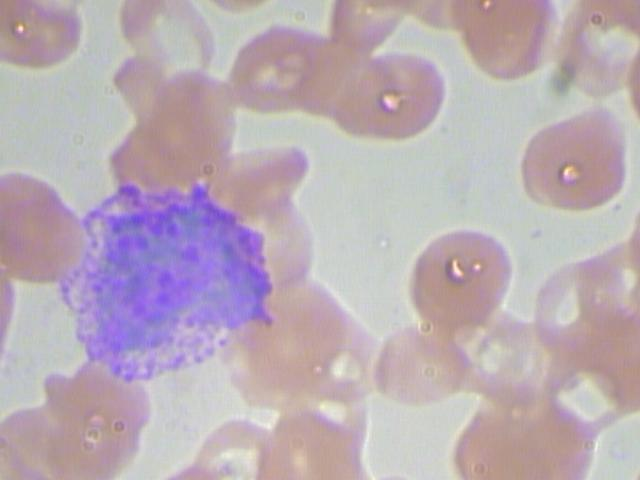

## Eosinophil
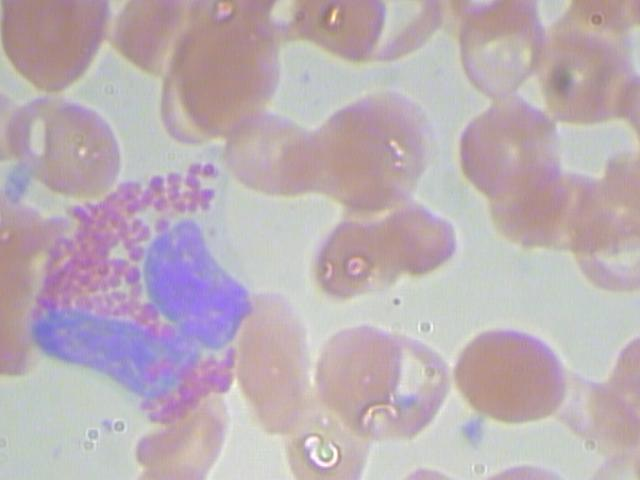

## Lymphocyte
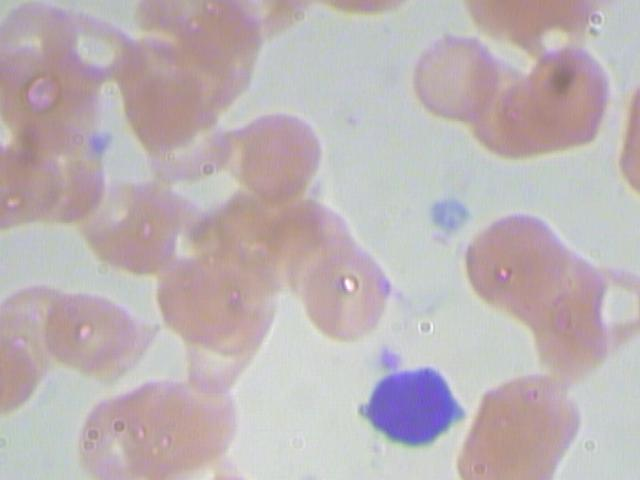

## Monocyte
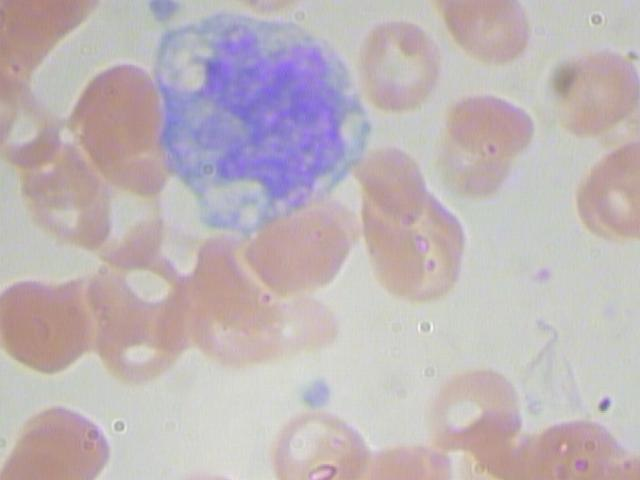

## Neutrophil
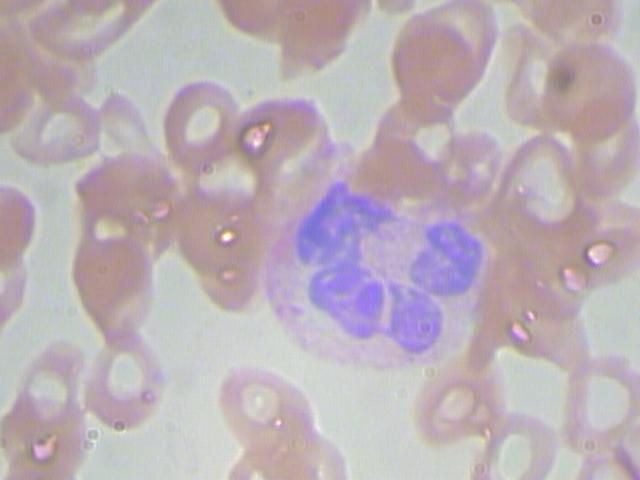

In [50]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import kagglehub
download_path = '/conent/'  # Specify your download path here
paultimothymooney_blood_cells_path = kagglehub.dataset_download('paultimothymooney/blood-cells')

print('Data source import complete.')


Data source import complete.


In [51]:
import shutil
import os

destination_path = '/content/'
for file_name in os.listdir(paultimothymooney_blood_cells_path):
    shutil.move(os.path.join(paultimothymooney_blood_cells_path, file_name), destination_path)

In [52]:
!ls /content/dataset2-master/dataset2-master/images/TRAIN

EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL


# Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

The torch module provides tensors and operations for them, as well as other utilities for working with PyTorch.

The torch.nn module provides classes for defining and training neural networks.

The torch.nn.functional module provides functions for working with neural networks, such as loss functions and activation functions.

The torch.optim module provides algorithms for optimizing neural network parameters.

The torchvision module provides utilities for working with image data, such as loading and preprocessing datasets.

The torchvision.transforms module provides functions for applying transformations to data, such as resizing and normalizing images.

# Dataset

In [21]:
# Load the datasets
train_dataset = torchvision.datasets.ImageFolder(
    root= destination_path + '/dataset2-master/dataset2-master/images/TRAIN',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

test_dataset = torchvision.datasets.ImageFolder(
    root= destination_path + '/dataset2-master/dataset2-master/images/TEST',
    transform=transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

In [22]:
# Get the list of label names
label_names = test_dataset.classes

# Print the label names
print(label_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


This code loads two datasets from image folders using the ImageFolder class from the torchvision.datasets module. The train_dataset and test_dataset variables will store the data from the respective folders.

The root parameter specifies the path to the root folder for each dataset. The transform parameter specifies a sequence of transformations that will be applied to each image in the dataset.

In this case, the transform applied to each image consists of three steps:

Resizing the image to a fixed size of (64, 64) using the Resize transformation.
Converting the image to a PyTorch tensor using the ToTensor transformation.
Normalizing the image tensor by subtracting the mean and dividing by the standard deviation of each channel, using the Normalize transformation. The mean and standard deviation values are provided as parameters to the Normalize transformation. These values are typically calculated from a large dataset of images and are used to standardize the data so that it is easier for the model to learn.

### Visualize the data

In [43]:
train_dataset.samples[1]

('/content//dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_1414.jpeg',
 0)

In [41]:
np.array(train_dataset.targets).shape

(9957,)

In [42]:
# Get unique labels and their frequencies
unique_labels, frequencies = np.unique(np.array(train_dataset.targets), return_counts=True)

# Print the results
for label, frequency in zip(unique_labels, frequencies):
    print(f"Label: {label}, Frequency: {frequency}")


Label: 0, Frequency: 2497
Label: 1, Frequency: 2483
Label: 2, Frequency: 2478
Label: 3, Frequency: 2499


In [ ]:


train_dataset.samples[1]

In [44]:
from PIL import Image
import matplotlib.pyplot as plt

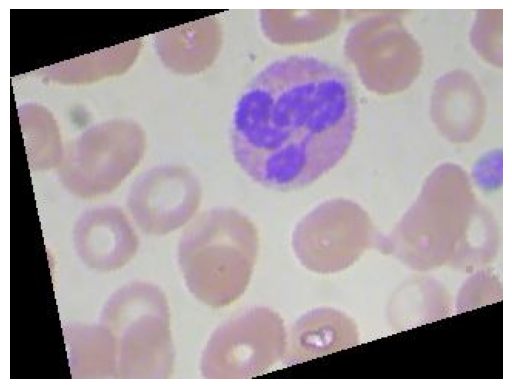

In [53]:
# Load the image
image_path = train_dataset.samples[10][0]  # Replace with your JPEG file path
img = Image.open(image_path)

# Plot the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()


### Create Dataloader

In [23]:
# Create dataloaders to load the data in batches
batch_size = 64 #In general, a larger batch size can lead to faster convergence and a better model performance, but it can also require more memory and computation. A smaller batch size can require more epochs to converge and may lead to a lower model performance, but it can be more memory-efficient and may be easier to fit on a single GPU.
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This code creates two data loaders, train_dataloader and test_dataloader, for the train_dataset and test_dataset respectively, using the DataLoader class from the torch.utils.data module.

A data loader is an iterator that yields a batch of data from a dataset at each iteration. It is useful for training a model with mini-batches of data, as it allows us to load the data in chunks rather than all at once, which can be more memory-efficient.

The batch_size parameter specifies the number of samples in each batch. The shuffle parameter specifies whether the data should be shuffled at each epoch (when training the model) or not (when evaluating the model).

The train_dataloader will load the training data in batches of size batch_size and shuffle the data at each epoch. The test_dataloader will load the test data in batches of size batch_size but will not shuffle the data.

# Model

In [24]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

This code defines a device variable which stores the device (CPU or GPU) on which the PyTorch tensors and operations will be run.

The torch.cuda.is_available() function returns True if a GPU is available and False otherwise. The device variable is then set to 'cuda' if a GPU is available, or 'cpu' otherwise.

Running tensors and operations on a GPU can significantly speed up the training of deep learning models, as GPUs are specifically designed to perform the matrix operations that are commonly used in deep learning. However, not all computers have a GPU, and some operations may not be supported on a GPU.

By setting the device to the appropriate value, we can ensure that the code will run on either the CPU or the GPU, depending on what is available. This allows us to write code that can run on any machine, regardless of whether it has a GPU or not.

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

This code defines a class called CNN which extends the nn.Module class from the torch.nn module. This is a PyTorch class for defining a neural network.

The CNN class has the following methods and attributes:

- __init__: This is the constructor for the class. It initializes the class by calling the superclass's constructor and defining the layers of the network. The network consists of four convolutional layers (conv1, conv2, conv3, conv4), four max pooling layers (pool1, pool2, pool3, pool4), and two fully-connected layers (fc1, fc2).

- forward: This method defines the forward pass of the network. It takes an input tensor x and applies a series of transformations to it using the layers defined in the constructor. The output of the forward pass is the prediction of the network.

The CNN class uses the nn.Conv2d class to define the convolutional layers and the nn.Linear class to define the fully-connected layers. The nn.MaxPool2d class is used to define the max pooling layers.

The forward method applies the ReLU activation function (defined in the torch.nn.functional module) to the output of each convolutional layer using the F.relu function. It also uses the view method to reshape the output of the last max pooling layer into a 1D tensor before passing it through the fully-connected layers. Finally, it applies a softmax function to the output of the second fully-connected layer to produce the final prediction of the network.

In [26]:
# Initialize the model
model = CNN().to(device)

# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

This code initializes a CNN model and defines the loss function and the optimizer that will be used to train the model.

The CNN model is initialized by calling the CNN constructor and passing it no arguments. The resulting model is then moved to the device specified by the device variable using the to method.

The loss function is defined using the nn.CrossEntropyLoss class from the torch.nn module. This is a common choice for classification tasks, as it measures the distance between the predicted class probabilities and the true class labels.

The optimizer is defined using the optim.Adam class from the torch.optim module. This is a widely-used optimization algorithm that adjusts the model's parameters based on the gradient of the loss function with respect to those parameters. The Adam optimizer takes the model's parameters as an argument and uses them to update the model during training.

# Training

In [27]:
# Define the number of epochs
num_epochs = 25

In [28]:
# Initialize an empty list to store the losses
losses = []

# Train the model
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append the loss to the list
    losses.append(loss.item())

    # Print the loss
    print(f'Loss at epoch {epoch+1}: {loss.item():.4f}')

Loss at epoch 1: 1.1086
Loss at epoch 2: 0.8544
Loss at epoch 3: 0.8037
Loss at epoch 4: 0.4382
Loss at epoch 5: 0.5557
Loss at epoch 6: 0.4450
Loss at epoch 7: 0.3276
Loss at epoch 8: 0.4702
Loss at epoch 9: 0.3602
Loss at epoch 10: 0.3156
Loss at epoch 11: 0.4015
Loss at epoch 12: 0.2424
Loss at epoch 13: 0.3665
Loss at epoch 14: 0.2062
Loss at epoch 15: 0.2840
Loss at epoch 16: 0.2647
Loss at epoch 17: 0.2072
Loss at epoch 18: 0.1529
Loss at epoch 19: 0.1121
Loss at epoch 20: 0.1418
Loss at epoch 21: 0.0970
Loss at epoch 22: 0.1484
Loss at epoch 23: 0.0139
Loss at epoch 24: 0.1482
Loss at epoch 25: 0.0602


This code trains the CNN model for a specified number of epochs using the training data from the train_dataloader data loader.

The for loop iterates over the number of epochs, and in each epoch the model is put in training mode using the model.train() method.

For each batch of inputs and labels in the training data, the input tensors are moved to the device specified by the device variable using the to method, and the label tensors are also moved to the device. The model is then applied to the input tensors using the model function to produce the logits (unnormalized probabilities).

The loss is then computed using the loss_fn function and the logits and labels.

The gradients of the loss with respect to the model's parameters are then computed using the backward method, and the optimizer is used to update the model's parameters using the step method.

After all the batches in an epoch have been processed, the loss for that epoch is appended to the losses list and is printed to the console.

**The loss values are decreasing over time, which is generally what you want to see during training. This suggests that the model is learning and improving over time.**

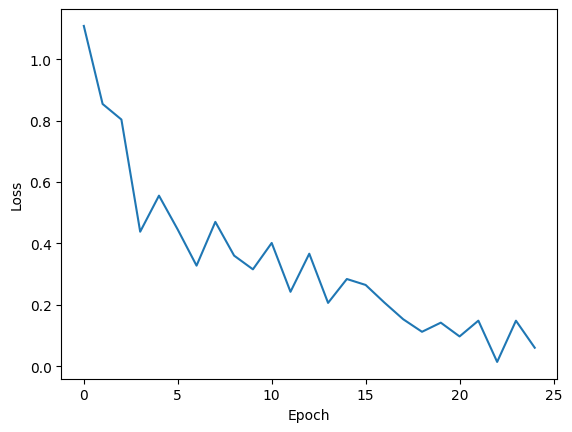

In [30]:
import matplotlib.pyplot as plt

# Plot the loss values
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

This code uses the matplotlib library to plot the loss values for each epoch of training.

The plt.plot function plots the values in the losses list as a line plot. The plt.xlabel and plt.ylabel functions set the labels for the x-axis and y-axis of the plot, respectively. The plt.show function displays the plot.

Plotting the loss values can be useful for understanding how the model is training and for detecting any patterns in the loss values.

# Testing and Evaluating

In [31]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np

# Set model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_probs = []  # store predicted probabilities instead of labels

# Iterate through the test data
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        logits = model(inputs)
        probs = torch.softmax(logits, dim=1)  # calculate probabilities

        # Add true labels and predicted probabilities to lists
        true_labels.extend(labels.tolist())
        pred_probs.extend(probs.tolist())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

# Calculate accuracy, F1 score, and AUC score
acc = accuracy_score(true_labels, np.argmax(pred_probs, axis=1))
f1 = f1_score(true_labels, np.argmax(pred_probs, axis=1), average='macro')
auc = roc_auc_score(true_labels, pred_probs, multi_class='ovo')

# Print results
print(f'Test accuracy: {acc:.4f}')
print(f'Test F1 score: {f1:.4f}')
print(f'Test AUC score: {auc:.4f}')

Test accuracy: 0.7290
Test F1 score: 0.7305
Test AUC score: 0.9109


This code evaluates the performance of the CNN model on the test data from the test_dataloader data loader.

The model.eval method sets the model to evaluation mode, which can disable certain features that are only used during training, such as dropout.

The for loop iterates through the test data, and for each batch of inputs and labels, the input tensors are moved to the device specified by the device variable and the label tensors are also moved to the device. The model is then applied to the input tensors to produce the logits, and the probabilities of each class are calculated using the torch.softmax function.

The true labels and predicted probabilities are added to the true_labels and pred_probs lists, respectively.

After all the batches in the test data have been processed, the true_labels and pred_probs lists are converted to numpy arrays.

The accuracy_score, f1_score, and roc_auc_score functions from the sklearn.metrics module are used to calculate the accuracy, F1 score, and area under the receiver operating characteristic curve (AUC) of the model on the test data, respectively. These are common evaluation metrics for classification tasks.

Finally, the results are printed to the console.

**The test accuracy is a measure of how well the model is able to classify the test data, and it is expressed as a percentage. A test accuracy of 0.8078 means that the model was able to correctly classify about 80% of the test examples. The F1 score is a measure of the model's precision and recall, and it is often used as a metric for evaluating the performance of a classifier. It is calculated as the harmonic mean of the precision and recall, with a higher score indicating better performance. A test F1 score of 0.8093 suggests that the model has good precision and recall on the test data. The AUC score is a measure of the model's ability to distinguish between positive and negative examples. It is calculated as the area under the ROC curve, and a higher score indicates better performance. A test AUC score of 0.9601 suggests that the model is able to distinguish between positive and negative examples with high accuracy. Overall, these test scores suggest that the trained CNN model is performing well on the test dataset.**

# Predicting

In [33]:
from PIL import Image

# Load the image and preprocess it
image = Image.open(destination_path +  '/dataset2-master/dataset2-master/images/TEST/MONOCYTE/_0_1123.jpeg')
preprocess = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image = preprocess(image)

# Convert the image to a PyTorch tensor and send it to the device
image = image.unsqueeze(0).to(device)

# Make the prediction
with torch.no_grad():
    logits = model(image)
    probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1)

# Print the prediction
print(f'Predicted label: {pred_label.item()}')

# Map the predicted label to the corresponding class name
predicted_class_name = label_names[pred_label.item()]

# Print the predicted class name
print(f'Predicted class name: {predicted_class_name}')

Predicted label: 2
Predicted class name: MONOCYTE
